![mini_house_in_boardroom](./images/mini_house_boardroom.jpeg)

# Real Estate Consulting for King County

#### Authors: Charlie, Gideon, Max

## Overview

[The King County Assessor department](https://info.kingcounty.gov/assessor/DataDownload/default.aspx)is a government agency in King County, Washington, responsible for assessing the value of real estate properties for tax purposes.

The office uses a database collection, which includes data on all the properties in the county, such as property dimensions, ownership information, sale history, and land use. This data is collected from various sources, including property deeds, building permits, surveys, and inspections.

Real estate companies can use the data provided by the King County Assessor's Office to optimize their ROI when flipping houses by identifying properties with the potential to increase in value. By analyzing the sale history, property dimensions, land use, and ownership information, companies can determine which properties are undervalued and have the potential for profit. This can help companies make informed decisions about which properties to invest in, and how much to invest.


## Business Problem

[Real Estate Company, King County Estates](https://kingcountyestates.com/about/the-team/), is looking to expand their portfolio in the King County Real Estate market but they are not sure about the trends in the market. So they've hired our data science team for insights into what property features they should pay attention to to return get the largest return on their investment.

We've developed a multiple linear regression model to give them better insights on the independent and dependent variables that best explain the relationship they have on varying property values.

Our conclusions after the below analysis include identifying:

1. House pricing is most correlated to the squarefeet of living space in a home.
2. On average, a home can expect a  \\$75,000 increase in value after a renovation.
3. Waterfront property is on averate \\$600,000 more than land locked property.
4. Zip codes play a big role on property value


## Data 
    
Our data comes from [The King County Assessor department](https://info.kingcounty.gov/assessor/DataDownload/default.aspx) and represents about 30,000 residential property sales from the years of 2021 and 2022 including information about property features and dimensions as well as sale prices.


# Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import statsmodels.stats.stattools
from scipy import stats

In [2]:
df = pd.read_csv('data/kc_house_data.csv')
#df.info()

## Converting column dtypes

In [3]:
# converting date column from str to int
df['date'] = pd.to_datetime(df['date']).dt.year

In [4]:
#extracting zip code from address and converting to int
df['zipcode'] = df['address'].str.extract(r'\b(\d{5})[,]\s*United States\b').astype('str')

In [5]:
df['nuisance'] = df['nuisance'].map({'YES': 0, 'NO': 1})
df['greenbelt'] = df['greenbelt'].map({'YES': 1, 'NO': 0})
df['waterfront'] = df['waterfront'].map({'YES': 1, 'NO': 0})

In [6]:
# creating new boolean column, 'renovated' for houses either renovated or not
df['renovated'] = (df['yr_renovated'] == 0).astype(int)
df['renovated'] = df['renovated'].map({1: 0, 0: 1})

In [7]:
extract_num = lambda x: int(x[:2])

# Apply the lambda function
df['grade'] = df['grade'].apply(extract_num)

In [8]:
#converted to dummy later for further analysis
#condish = {'Poor': 1,'Fair': 2, 'Average': 3, 'Good': 4, 'Very Good': 5}
#f.condition = [condish[item] for item in df.condition]

## Filtering out rows not in King County

**URL for King County Coordinate info: [King County Coordinates](https://www5.kingcounty.gov/sdc/FGDCDocs/ZIPCODE_fgdc.htm)**

In [9]:
#filtering out adresses not in Washington
df_wash = df[df['address'].str.contains('Washington')]
#df_wash.info()

In [10]:
df_king = df_wash[(df_wash['lat'] >= 46.71) 
                       & (df['lat'] <= 48.31) 
                       & (df['long'] >= -123.07) 
                       & (df['long'] <= -119.90)]
#df_king.info()

## Dropping Null, Duplicate, High-Corrilinearity and Unecessary Columns

In [11]:
df_king.drop_duplicates(inplace=True)
df_king.dropna(inplace=True)
#df_king.info()

In [12]:
# save absolute value of correlation matrix as a data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df=df_king.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#d rop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.

df.drop_duplicates(inplace=True)

In [13]:
print(df[(df.cc>.50) & (df.cc <1)])

                                  cc
pairs                               
(yr_renovated, renovated)   0.999958
(sqft_above, sqft_living)   0.881728
(bathrooms, sqft_living)    0.779853
(sqft_living, grade)        0.739160
(sqft_above, grade)         0.720495
(sqft_above, bathrooms)     0.680877
(grade, bathrooms)          0.653074
(sqft_living, bedrooms)     0.630945
(price, sqft_living)        0.616701
(bedrooms, bathrooms)       0.593563
(grade, price)              0.578032
(sqft_above, sqft_garage)   0.553834
(sqft_above, price)         0.546077
(sqft_above, bedrooms)      0.537878
(yr_built, floors)          0.521346
(sqft_garage, grade)        0.516233
(sqft_above, floors)        0.505068
(sqft_living, sqft_garage)  0.503639


In [14]:
df_king.drop(['id', 'address', 'sqft_above', 'sqft_lot', 'sqft_basement', 'bathrooms', 'grade', 'bedrooms',
              'sqft_garage', 'floors'], axis=1, inplace=True)

- saving 'yr_built' for data wrangling later

# Data Understanding

## Methods

We will be analyzing the housing data to create a multiple linear regression model using methods such as data cleaning, exploratory data analysis, feature selection, and model training using statistical tools such as Python and more specifically it's statsmodels packages. We'll be using inferential statistics to make conclusions about the relationships between variables and to assess the significance of coefficients. However, it is important to note that inferential statistics are not enough to make predictive conclusions about future housing prices, as the model may not capture all relevant variables, and unforeseeable events can affect the housing market in unpredictable ways.



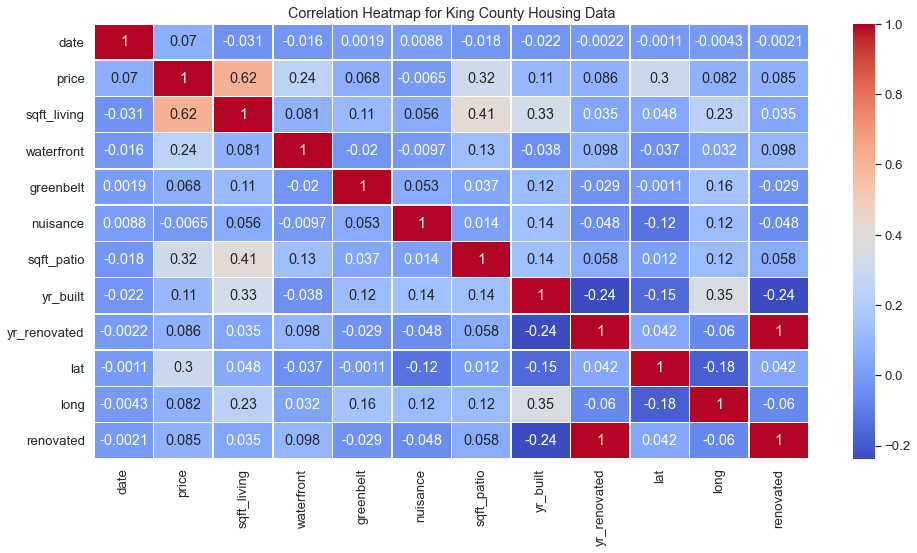

In [15]:
corr_matrix = df_king.corr(method='pearson')

sns.set(font_scale=1.2)
plt.figure(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap for King County Housing Data")
plt.show()

- Examining the heatmap, it appears that the Square Feet of Living Space in a home exhibits the strongest correlation coefficient with respect to housing prices. Consequently, using this feature as the basis for a model is logical, as one would intuitively assume that the size of a home, measured in square feet, significantly influences its price.

# Modeling
 
We chose **sqft of living** as our base model for the dependent variable 'price' because it showed the highest correlation with 'price' among all the features in the dataset. The correlation coefficient indicates the strength of a relationship between two variables, and the sqft of living had the highest correlation coefficient with 'price'. Additionally, when we used the sqft of living as the independent variable in a regression model, it had the highest R-squared value, which means that it explained the most variation in the values of 'price'. Lastly, the assumption testing performed on this model was the best among all the features, which means that the model met the assumptions required for regression analysis. Hence, we chose the sqft of living as our base model for the dependent variable 'price' as it was the best predictor of 'price' among all the features in the dataset.

## Creating A Base Model with highest correlated feature

In [16]:
y = df_king['price']
X = df_king['sqft_living']

base_model = sm.OLS(y, sm.add_constant(X)).fit()


print(base_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                 1.792e+04
Date:                Sat, 01 Apr 2023   Prob (F-statistic):               0.00
Time:                        01:25:04   Log-Likelihood:            -4.3459e+05
No. Observations:               29197   AIC:                         8.692e+05
Df Residuals:                   29195   BIC:                         8.692e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.227e+04   9904.112     -9.317      

<Figure size 720x576 with 0 Axes>

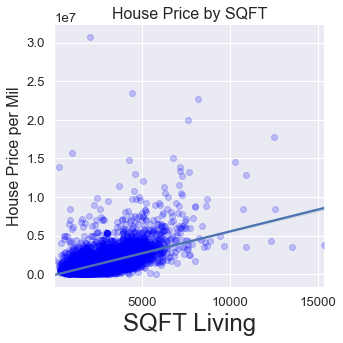

In [17]:
plt.figure(figsize=(10, 8))
sns.lmplot(data=df_king, x="sqft_living", y="price", fit_reg=True, scatter_kws = {'color': 'blue', 'alpha': 0.2})
plt.xlabel('SQFT Living', fontsize=24) 
plt.ylabel('House Price per Mil', fontsize=16)
plt.title('House Price by SQFT', fontsize=16)
plt.tight_layout()
plt.savefig('images/sqft_living_base.jpg', facecolor='white')

In [18]:
from statsmodels.stats.diagnostic import het_breuschpagan
het_breuschpagan(base_model.resid, sm.add_constant(X))

(343.0170136794241,
 1.4054878852769867e-76,
 347.07103414868413,
 5.152148079065719e-77)

#### Assumption Tests and Analysis:
- Passes **multicollinearity** with cond. no. 132 (under 1,000)
- Passes **independence** with a Durbin-Watson of almost exactly 2 saying there is no significant autocorrelation
- Fails **normality** Omnibus and Jarque-Bera low p-values suggest that the data is not normally distributed
- Slightly skewed left
- 9.079 Kurtosis indicates that the distribution has heavier tails (more spread out)

In [19]:
from statsmodels.stats.diagnostic import linear_rainbow
linear_rainbow(base_model)

(1.2167889998731811, 1.1605640760099133e-32)

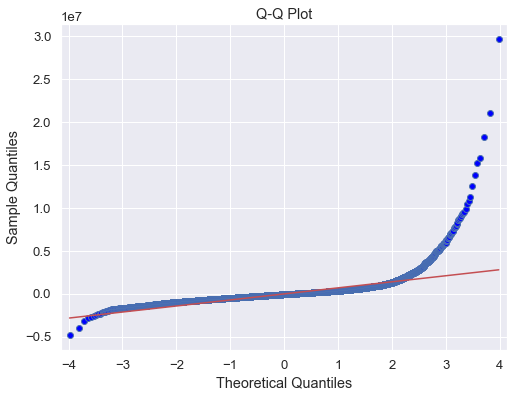

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(base_model.resid,line='s',ax=ax)
ax.set_title('Q-Q Plot')
plt.show()

In [21]:
base_model.summary().tables[2]

Omnibus:,42260.401,Durbin-Watson:,1.938
Prob(Omnibus):,0.000,Jarque-Bera (JB):,50099131.216
Skew:,8.237,Prob(JB):,0.00
Kurtosis:,205.263,Cond. No.,5.63e+03


- with omnibus and Jarque-Bera having small p-values this suggests that we cannot reject the null-hypothesis that the base model data is normally distributed.
- Also with a Kurtosis greater than 3 this would suggest that the distribution is heavilyt tailed/spread out
- Therefore this model does not pass normality assumption and we can not assume that this model is normally distributed

In [22]:
from statsmodels.stats.diagnostic import het_breuschpagan
het_breuschpagan(base_model.resid, sm.add_constant(X))

(343.0170136794241,
 1.4054878852769867e-76,
 347.07103414868413,
 5.152148079065719e-77)

#### larger p-values for Lagrange Multiplier and Breuschpagan suggest that this base model passes Homoscedasticity Assumption

# Examining other features to add for multiple regression

### I. One-Hot encoding categorical data to see if any sub category has a stronger correlation with price than current variables:
- zipcode
- heat_source
- sewer_system

#### A. Zipcodes

In [23]:
df_dummy_zip = df_king.copy()

In [24]:
# Get unique zipcodes
unique_zipcodes = df_dummy_zip['zipcode'].unique()

# Convert column 'zipcode' into dummy columns
df_zip = pd.get_dummies(df_dummy_zip, columns=['zipcode'], prefix='zip')

# Create a list of new dummy zipcode columns
zip_col = [f'zip_{zipcode}' for zipcode in unique_zipcodes]

# Define the most correlated column
most_correlated = 'sqft_living'

# Select the most correlated column and new dummy zipcode columns
X_iterated = df_zip[[most_correlated] + zip_col]

In [25]:
#X_iterated.corr()['price'].sort_values(ascending=False).head(10)

In [26]:
zip_dummy_base = X_iterated.drop('zip_98042', axis=1)

In [27]:
iterated_model = sm.OLS(y, sm.add_constant(zip_dummy_base))
iterated_results = iterated_model.fit()
#print(iterated_results.summary())

#### B. Heat_Source

In [28]:
df_dummy_heat = df_king.copy()

In [29]:
# Get unique zipcodes
heat_systems = df_dummy_heat['heat_source'].unique()

# Convert column 'zipcode' into dummy columns
df_heat = pd.get_dummies(df_dummy_heat, columns=['heat_source'], prefix='heat_source')

# Create a list of new dummy zipcode columns
heat_col = [f"heat_source_{heat_source}" for heat_source in heat_systems]

# Define the most correlated column
most_correlated2 = 'sqft_living'

# Select the most correlated column and new dummy zipcode columns
X_iterated2 = df_heat[[most_correlated2] + heat_col]

In [30]:
#df_dummy_heat['heat_source'].value_counts()

In [31]:
#X_iterated2.corr()['sqft_living'].sort_values(ascending=False)

In [32]:
heat_dum_base = X_iterated2.drop('heat_source_Gas', axis=1)

In [33]:
iterated_model2 = sm.OLS(y, sm.add_constant(heat_dum_base))
iterated_results2 = iterated_model2.fit()
#print(iterated_results2.summary())

#### C. sewer_system

In [34]:
df_dummy_sewer = df_king.copy()

In [35]:
# Get unique zipcodes
sewer_systems = df_dummy_sewer['sewer_system'].unique()

# Convert column 'zipcode' into dummy columns
df_sewer = pd.get_dummies(df_dummy_sewer, columns=['sewer_system'], prefix='sewer_system')

# Create a list of new dummy zipcode columns
zip_col3 = [f"sewer_system_{sewer_system}" for sewer_system in sewer_systems]

# Define the most correlated column
most_correlated3 = 'sqft_living'

# Select the most correlated column and new dummy zipcode columns
X_iterated3 = df_sewer[[most_correlated3] + zip_col3]

In [36]:
#df_dummy_sewer['sewer_system'].value_counts()

In [37]:
sewer_dum_base = X_iterated3.drop('sewer_system_PUBLIC', axis=1)

In [38]:
iterated_model3 = sm.OLS(y, sm.add_constant(sewer_dum_base))
iterated_results3 = iterated_model3.fit()
#print(iterated_results3.summary())

Assumption Tests and Analysis:
Fails multicollinearity with cond. no. higher than 1000 (may be able to pass after removing outliers)
Passes independence with a Durbin-Watson of almost exactly 2 saying there is no significant autocorrelation
Fails normality Omnibus and Jarque-Bera low p-values suggest that the data is not normally distributed
Slightly skewed left
9.079 Kurtosis indicates that the distribution has heavier tails (more spread out)

#### D. condition

In [39]:
df_dummy_condtion = df_king.copy()

In [40]:
# Get unique zipcodes
conditions = df_dummy_condtion['condition'].unique()

# Convert column 'zipcode' into dummy columns
df_con = pd.get_dummies(df_dummy_condtion, columns=['condition'], prefix='condition')

# Create a list of new dummy zipcode columns
con_col = [f"condition_{condition}" for condition in conditions]

# Define the most correlated column
most_correlated4 = 'sqft_living'

# Select the most correlated column and new dummy zipcode columns
X_iterated4 = df_con[[most_correlated4] + con_col]

In [41]:
con_dum_base = X_iterated4.drop('condition_Average', axis=1)

In [42]:
iterated_model4 = sm.OLS(y, sm.add_constant(con_dum_base))
iterated_results4 = iterated_model4.fit()

In [43]:
#print(iterated_results4.summary())

#### E. yr_renovated

In [44]:
df_dummy_ren = df_king.copy()

In [45]:
#df_dummy_ren['yr_renovated'].value_counts()

In [46]:
# Get unique zipcodes
renovations = df_dummy_ren['yr_renovated'].unique()

# Convert column 'zipcode' into dummy columns
df_ren = pd.get_dummies(df_dummy_ren, columns=['yr_renovated'], prefix='yr_renovated')

# Create a list of new dummy zipcode columns
ren_col = [f"yr_renovated_{yr_renovated}" for yr_renovated in renovations]

# Define the most correlated column
most_correlated6 = 'sqft_living'

# Select the most correlated column and new dummy zipcode columns
X_iterated6 = df_ren[[most_correlated6] + ren_col]

In [47]:
grade_dum_base = X_iterated6.drop('yr_renovated_2021', axis=1)

In [48]:
iterated_model6 = sm.OLS(y, sm.add_constant(grade_dum_base))
iterated_results6 = iterated_model6.fit()
#print(iterated_results6.summary())

## Checking boolean features

In [49]:
columns = ['sqft_living', 'waterfront']

y = df_king['price']
X = df_king[columns]

water_model = sm.OLS(y, sm.add_constant(X)).fit()


#print(water_model.summary())

In [50]:
columns2 = ['sqft_living', 'greenbelt']

y = df_king['price']
X = df_king[columns2]

green_model = sm.OLS(y, sm.add_constant(X)).fit()


#print(green_model.summary())

In [51]:
columns3 = ['sqft_living', 'nuisance']

y = df_king['price']
X = df_king[columns3]

nuisance_model = sm.OLS(y, sm.add_constant(X)).fit()


#print(nuisance_model.summary())

In [52]:
columns4 = ['sqft_living', 'renovated']

y = df_king['price']
X = df_king[columns4]

renovation_model = sm.OLS(y, sm.add_constant(X)).fit()


#print(renovation_model.summary())

# Final Model


- We added zip codes, renovation, and waterfront properties to our base model to create a final model with a higher R-squared value. These features were independent of each other and had high statistically significant coefficients, indicating that they played a vital role in predicting the price of a home. Furthermore, their inclusion in the model resulted in better performance when running assumption tests. Hence, by adding these features, we were able to create a more accurate model that could explain a higher proportion of the variation in home prices.

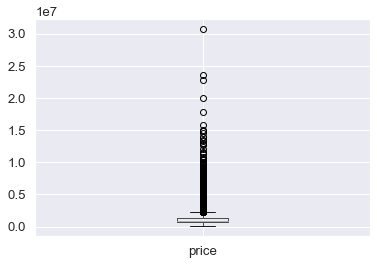

In [53]:
df_king.boxplot(column=['price'])

plt.show()

In [54]:
len(df_king)

29197

In [55]:
df_king_final = df_king[(df_king['price'] <= 5000000)]
len(df_king_final)

29002

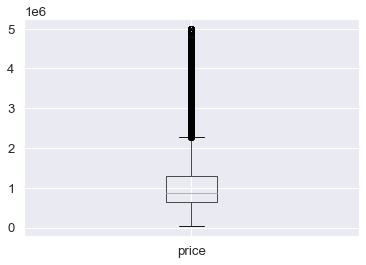

In [56]:
df_king_final.boxplot(column=['price'])

plt.show()

In [57]:
# Get unique zipcodes
unique_zipcodes2 = df_king_final['zipcode'].unique()

# Convert column 'zipcode' into dummy columns
df_zip2 = pd.get_dummies(df_king_final, columns=['zipcode'], prefix='zipcode')

# Create a list of new dummy zipcode columns
zip_col2 = [f"zipcode_{zipcode}" for zipcode in unique_zipcodes2]

# Define the most correlated column
most_correlated = 'sqft_living'

# Select the most correlated column and new dummy zipcode columns
X_iterated_final = df_zip2[[most_correlated] + ['price']  + zip_col2 + ['renovated'] + ['waterfront']]

In [58]:
zip_dummy_final = X_iterated_final.drop('zipcode_98042', axis=1)

In [59]:
y_final = zip_dummy_final['price']
x_final = zip_dummy_final.drop('price', axis = 1)
model_final = sm.OLS(y_final, sm.add_constant(x_final)).fit()

In [60]:
print(model_final.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     769.3
Date:                Sat, 01 Apr 2023   Prob (F-statistic):               0.00
Time:                        01:25:06   Log-Likelihood:            -4.1239e+05
No. Observations:               29002   AIC:                         8.250e+05
Df Residuals:                   28912   BIC:                         8.257e+05
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.521e+05   1.27e+04    -11.968

## Results:

- The final model has an R-squared of 0.703, indicating that the explanatory variables in the final model explain 70.3% of the variation in the price of the house.

- The final model has 89 explanatory variables, which include zip codes, renovating status, and waterfront property. Each variable has a coefficient, a standard error, a t-value, and a p-value, which are used to determine its significance. In the final model, all the variables are significant (p < 0.05), except for one zip code.

- Overall, the final model performs better than the base model because it includes more relevant explanatory variables, providing a better prediction of the price of a house. Regular business people can use the final model to estimate the price of a house based on its features. For example, they can input the square footage of the living area, the zip code, and the renovating status, and the model will predict the price of the house.


### Testing Assumptions of Final Model

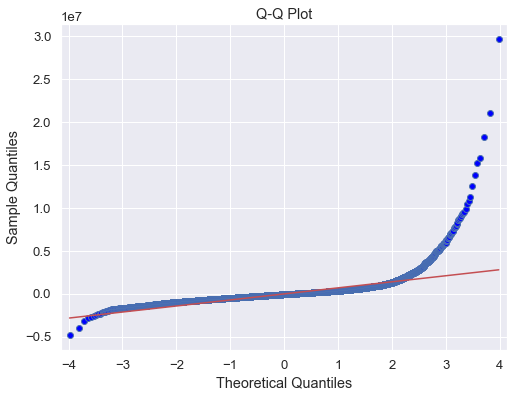

In [61]:
#Linearity
fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(base_model.resid,line='s',ax=ax)
ax.set_title('Q-Q Plot')
plt.show()

In [62]:
from statsmodels.stats.diagnostic import het_breuschpagan
het_breuschpagan(model_final.resid, sm.add_constant(x_final))

(2774.663158194411, 0.0, 34.36720411122348, 0.0)

In [63]:
from statsmodels.stats.diagnostic import linear_rainbow
linear_rainbow(model_final)

(1.041958978319512, 0.0067385132726375625)

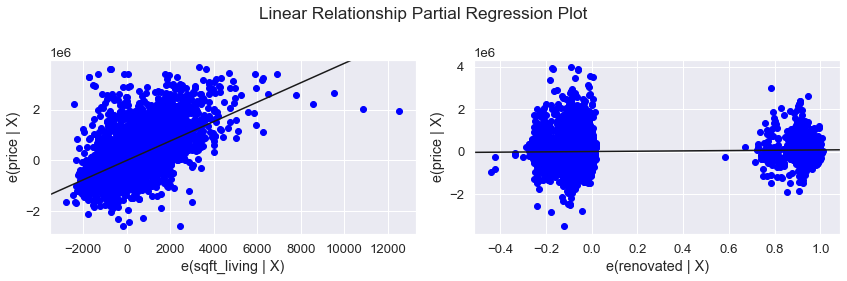

In [64]:
fig = plt.figure(figsize=(12,4))
sm.graphics.plot_partregress_grid(model_final, exog_idx=["sqft_living", "renovated"], fig=fig)

# with marker 'o', so what looks like a scatter plot is a "line" internally, so

for ax in fig.axes:
    ax.lines[0].set_color("blue")
fig.suptitle("Linear Relationship Partial Regression Plot", fontsize="large")
plt.tight_layout()
plt.savefig('images/sqft_living_final.jpg', facecolor='white')
plt.show()

In [65]:
model_final_ex = sm.OLS(y_final, sm.add_constant(x_final))

In [66]:
n2 = model_final.nobs

# Taking the middle 50%, so ignoring the first 25% and last 25%
lower_bound = int(np.ceil(n2 * 0.25))
upper_bound = int(np.floor(n2 * 0.75))

# Take subsets of y and X
subset_y = model_final_ex.endog[lower_bound:upper_bound]
subset_X = model_final_ex.exog[lower_bound:upper_bound]

In [67]:
subset_model = sm.OLS(subset_y, subset_X)
subset_results = subset_model.fit()

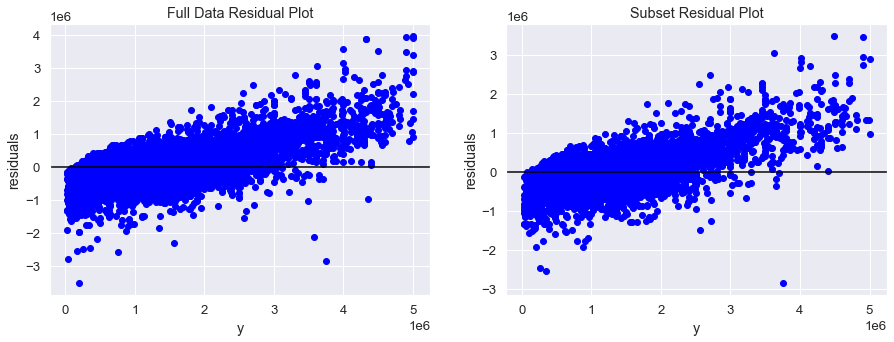

In [68]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))

axes[0].scatter(model_final_ex.endog, model_final.resid, color="blue")
axes[0].set_title("Full Data Residual Plot")

axes[1].scatter(subset_y, subset_results.resid, color="blue")
axes[1].set_title("Subset Residual Plot")

for ax in axes:
    ax.set_xlabel("y")
    ax.set_ylabel("residuals")
    ax.axhline(y=0, color="black")

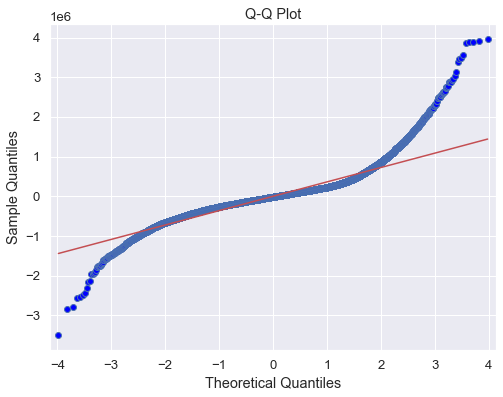

In [69]:
#qq plot to show normality

fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(model_final.resid,line='s',ax=ax)
ax.set_title('Q-Q Plot')
plt.show()

# Conclusions

- On average, our findings show that properties are valued at \\$382 per square foot. Additionally, renovating the property can increase its value by an average of $72,000, and owning a waterfront property can yield an average of \\$682,000 in extra income. Lastly, we found that zip codes play a crucial role in determining property value. These insights can help guide your investment strategy and maximize your returns.

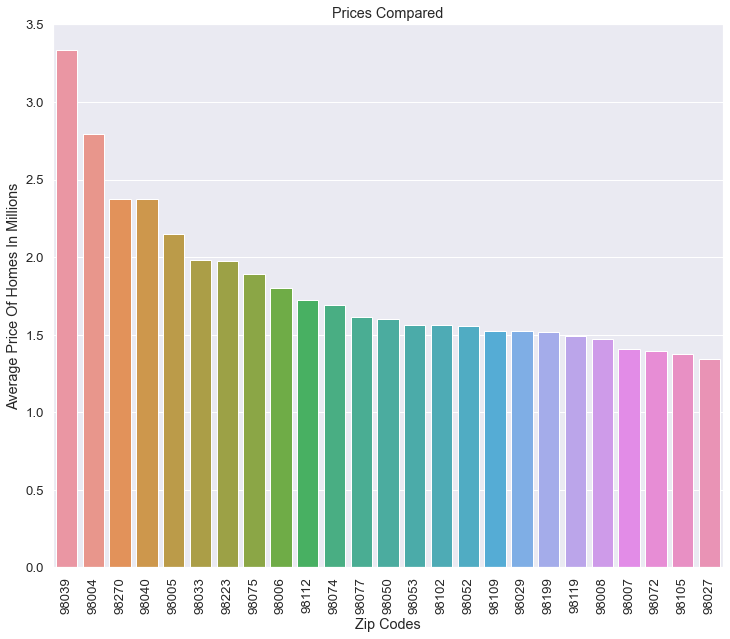

In [70]:
result = df_king_final.groupby(['zipcode'])['price'].mean().sort_values(ascending=False).head(25)
# plot the result
fig, ax = plt.subplots(figsize=(12,10))

g=sns.barplot(x = result.index, y = result.values/1000000, )
g.set_xlabel('Zip Codes')
plt.xticks(rotation=90)
g.set_ylabel('Average Price Of Homes In Millions')
g.set_title('Prices Compared')

plt.savefig('images/Renovationprice.jpg')

<Figure size 720x576 with 0 Axes>

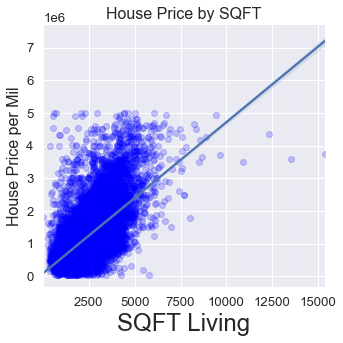

In [71]:
plt.figure(figsize=(10, 8))
sns.lmplot(data=zip_dummy_final, x="sqft_living", y="price", fit_reg=True, scatter_kws = {'color': 'blue', 'alpha': 0.2})
plt.xlabel('SQFT Living', fontsize=24) 
plt.ylabel('House Price per Mil', fontsize=16)
plt.title('House Price by SQFT', fontsize=16)
plt.tight_layout()

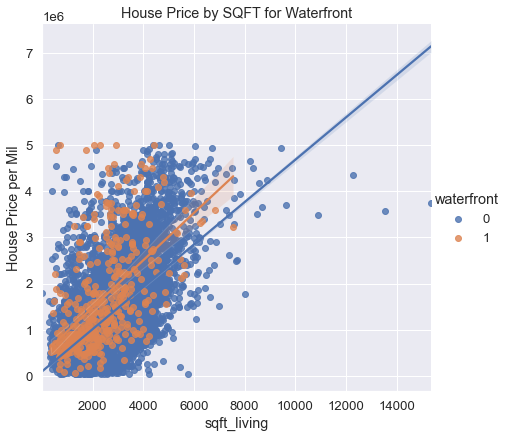

In [72]:
sns.lmplot(data=zip_dummy_final, x="sqft_living", y="price", hue='waterfront', height=6, fit_reg=True)
plt.ylabel('House Price per Mil')
plt.title('House Price by SQFT for Waterfront')
plt.savefig('images/Waterfront.jpg');

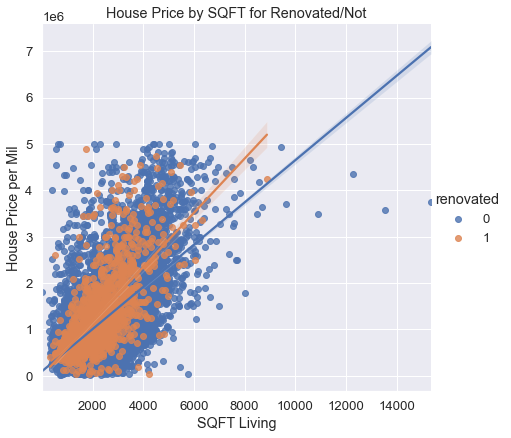

In [73]:
sns.lmplot(data=zip_dummy_final, x="sqft_living", y="price", hue='renovated', height=6, fit_reg=True)
plt.xlabel('SQFT Living')
plt.ylabel('House Price per Mil')
plt.title('House Price by SQFT for Renovated/Not')
plt.savefig('images/renovated.jpg');

# Addendum

### Using our model we can estimate Average price of the average sized home located on waterfronts that are due for renovations 

In [74]:
df_waterfront = df_king_final[(df_king_final['waterfront'] == 1) & 
                              (df_king_final['yr_built'] <= 2001) ]
df_waterfront['renovated'].value_counts()

0    304
1     84
Name: renovated, dtype: int64

In [75]:
df_print = df_waterfront.groupby(['renovated'])['price'].mean()
df_print

renovated
0    1.526430e+06
1    1.807126e+06
Name: price, dtype: float64

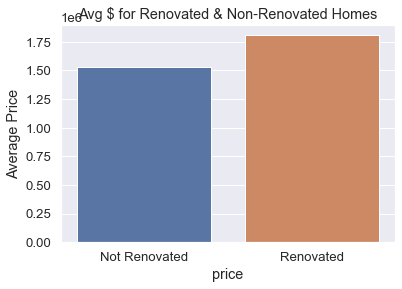

In [76]:
ax = sns.barplot(data=df_print, x=df_print.index, y=df_print.values)

if len(df_print.index) == 2:
    xtick_labels = ['Not Renovated', 'Renovated']
    ax.set_xticklabels(xtick_labels)
else:
    print("Error: There should be exactly two unique values in the 'renovated' column")
    
ax.set_ylabel('Average Price')
ax.set_title('Avg $ for Renovated & Non-Renovated Homes')

plt.savefig('images/water_no_ren.jpg')
plt.show();  

<AxesSubplot:>

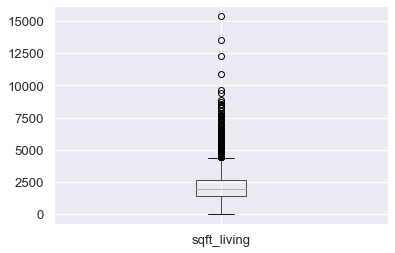

In [77]:
df_king_final.boxplot(column=['sqft_living'])

<AxesSubplot:>

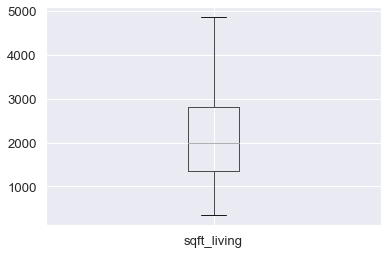

In [78]:
df_waterfront_no_ren = df_waterfront[(df_waterfront['renovated'] == 0) 
                                     & (df_waterfront['sqft_living'] <= 4900)]
df_waterfront_no_ren.boxplot(column=['sqft_living'])

In [79]:
avg_sqft_water2 = df_waterfront_no_ren['sqft_living'].mean()
sqft_coef2 = 382 - 10
water_coef2 = 6100000 - 71000
waterfront_no_ren_estimated_sale_price2 = avg_sqft_water2 * sqft_coef2 + water_coef2
waterfront_no_ren_estimated_sale_price2.astype(int)

6816661

In [80]:
avg_sqft_water = df_waterfront_no_ren['sqft_living'].mean()
sqft_coef = 382 
water_coef = 6100000
waterfront_no_ren_estimated_sale_price = avg_sqft_water * sqft_coef + water_coef
waterfront_no_ren_estimated_sale_price.astype(int)

6908834

## Next Steps

####  What Makes A Zipcode Hot?:
- We like to see what it is about zip code that makes it a huge factor. Proximity to freeways, malls, shopping, parks, playgrounds, bus stations?

####  Are There Any Zipcodes that could get Hot?:
- Are there indicators that zipcodes could be trending toward gentrification?

#### Renovation Deep Dive:

- What specific types of renovations are going to provide the most value. In flipping a home?

